In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [290]:
data = pd.read_csv("titanic/train.csv")
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [291]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [292]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [293]:
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)
data["Title"] = data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12848\1129116531.py:3: SyntaxWarning: invalid escape sequence '\.'
  data["Title"] = data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)


In [294]:
y = data["Survived"]
X = data.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Cabin"])

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [295]:
low_cardinality_cols = [col for col in X.columns if X[col].nunique() < 10 and X[col].dtype == "object"]
numerical_cols = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]

my_cols = low_cardinality_cols + numerical_cols
X = X[my_cols].copy()



In [296]:
numerical_transformer = SimpleImputer(strategy="mean")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, low_cardinality_cols),
    ]
)

In [297]:
my_model = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.08, n_jobs = 5)

my_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", my_model)
])

# my_pipeline.fit(X_train, y_train)
# preds = my_pipeline.predict(X_valid)

# print("Accuracy: ", accuracy_score(y_valid, preds))

In [298]:
cross_val_score(my_pipeline, X, y, cv=20, scoring="accuracy").mean()

0.8316919191919192

In [299]:
# OH_encode = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# OH_cols_train = pd.DataFrame(OH_encode.fit_transform(X_train[low_cardinality_cols]))
# OH_cols_valid = pd.DataFrame(OH_encode.transform(X_valid[low_cardinality_cols]))

# OH_cols_train.index = X_train.index
# OH_cols_valid.index = X_valid.index

# num_X_train = X_train[numerical_cols]
# num_X_valid = X_valid[numerical_cols]

# OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# OH_X_train.columns = OH_X_train.columns.astype(str)
# OH_X_valid.columns = OH_X_valid.columns.astype(str)

# OH_X_train.head(10)

In [300]:
# X_train_plus = OH_X_train.copy()
# X_valid_plus = OH_X_valid.copy()

# cols_with_missing = [col for col in X_train_plus.columns if X_train_plus[col].isnull().any()]


# for col in cols_with_missing:
#     X_train_plus[col + "_was_missing"] = X_train_plus[col].isnull()
#     X_valid_plus[col + "_was_missing"] = X_valid_plus[col].isnull()

# myimputer = SimpleImputer()
# imputed_X_train = pd.DataFrame(myimputer.fit_transform(X_train_plus))
# imputed_X_valid = pd.DataFrame(myimputer.transform(X_valid_plus))

# imputed_X_train.columns = X_train_plus.columns
# imputed_X_valid.columns = X_valid_plus.columns

In [301]:
# my_model = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.1, n_jobs = 5, early_stopping_rounds=10)
# my_model.fit(imputed_X_train, y_train, eval_set=[(imputed_X_valid, y_valid)], verbose=False)


In [302]:
# predictions = my_model.predict(imputed_X_valid)
# accuracy = accuracy_score(y_valid, predictions)

# print("Accuracy:", accuracy)

In [303]:
titanic_test_data = pd.read_csv("titanic/test.csv")
titanic_test_data["FamilySize"] = titanic_test_data["SibSp"] + titanic_test_data["Parch"] + 1
titanic_test_data["IsAlone"] = (titanic_test_data["FamilySize"] == 1).astype(int)
titanic_test_data["Title"] = titanic_test_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

my_pipeline.fit(X, y)
preds = my_pipeline.predict(titanic_test_data)
submission = pd.DataFrame({
    "PassengerId": titanic_test_data["PassengerId"],
    "Survived": preds
})
submission.to_csv("submission.csv", index=False)
submission

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12848\43630611.py:4: SyntaxWarning: invalid escape sequence '\.'
  titanic_test_data["Title"] = titanic_test_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


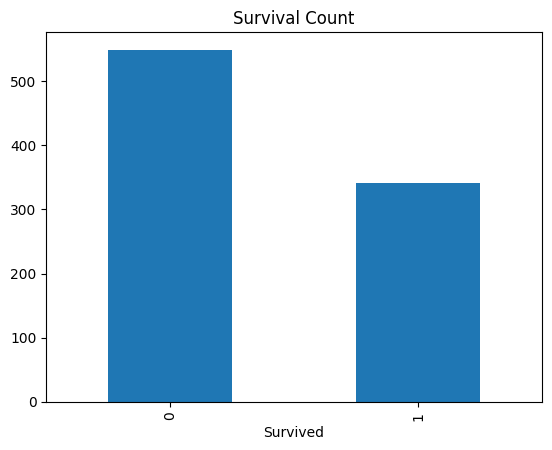

In [304]:
data["Survived"].value_counts().plot(kind="bar", title="Survival Count")
plt.show()


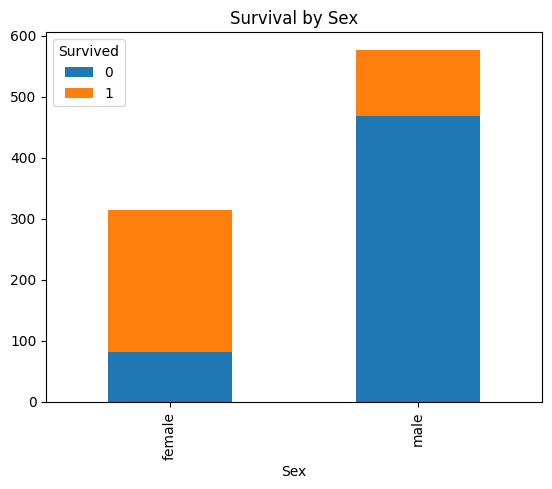

In [305]:
pd.crosstab(data["Sex"], data["Survived"]).plot(kind="bar", stacked=True)
plt.title("Survival by Sex")
plt.show()


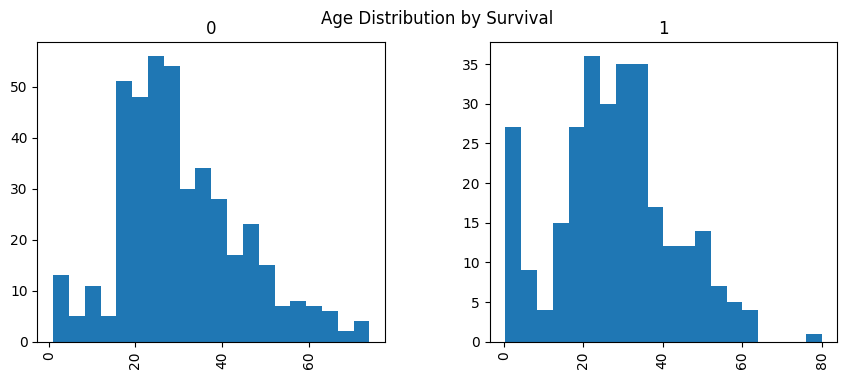

In [306]:
data["Age"].hist(by=data["Survived"], bins=20, figsize=(10, 4))
plt.suptitle("Age Distribution by Survival")
plt.show()


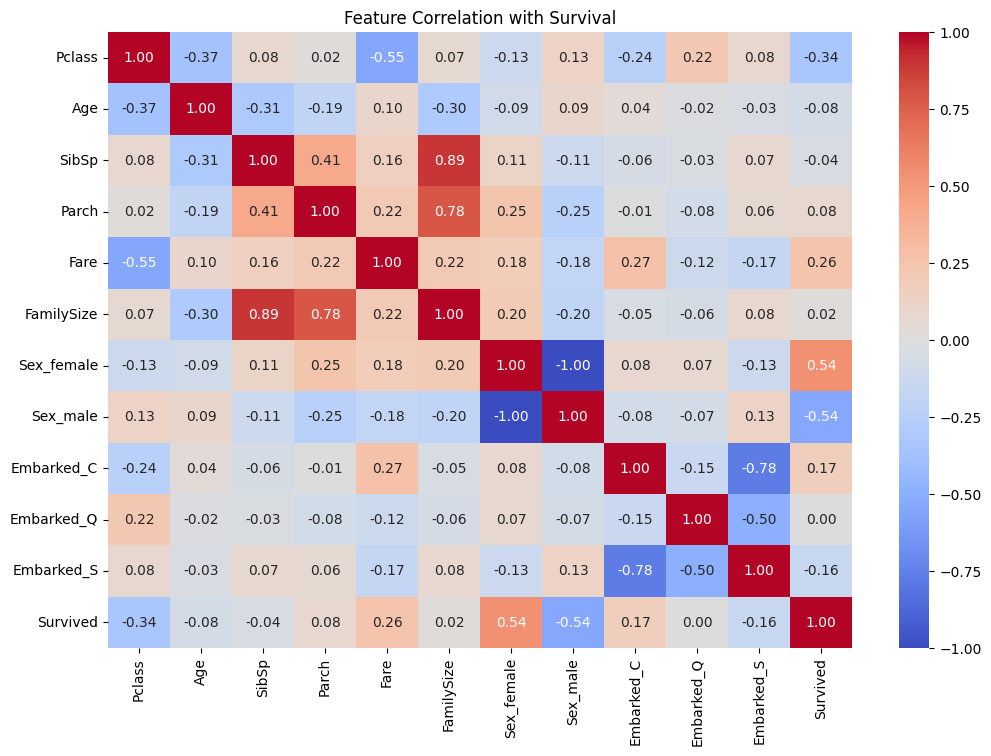

In [307]:
import seaborn as sns
encoded = pd.get_dummies(data[my_cols])
encoded["Survived"] = y
plt.figure(figsize=(12,8))
sns.heatmap(encoded.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Correlation with Survival")
plt.show()
